In [1]:
# SetFit funktioniert aktuell nicht mit Transformers 5.x. Beim Import knallt es
# mit einem ImportError (default_logdir wurde in 5.0 entfernt).
# Deshalb pinnen wir Transformers auf 4.x, bis SetFit das gefixt hat.
# Siehe: https://github.com/huggingface/setfit/issues/629

!pip install -U -q "transformers<5.0" setfit datasets sentence-transformers scikit-learn seaborn matplotlib snorkel

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import torch
import numpy as np
import os
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix
from datasets import Dataset
from setfit import SetFitModel, Trainer, TrainingArguments
from snorkel.labeling import PandasLFApplier, LabelingFunction
from snorkel.labeling.model import LabelModel

# Ggf folgendes noch ausführen
# from google.colab import drive
# drive.mount('/content/drive')

# Warnungen unterdrücken
warnings.filterwarnings("ignore")
os.environ["WANDB_DISABLED"] = "true"

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive


In [2]:
# Laden der CSV-Datei aus meinem Google Drive Verzeichnis
# 'encoding=latin1' für Sonderzeichen wie ä in Dräxlmaier
datensatz = pd.read_csv('/content/drive/MyDrive/data_PDA.csv', sep=';', encoding='latin1')

# Whitespace-Bereinigung:
# Damit Firmen wie "Bosch " und "Bosch" als identisch erkannt werden.
# Sonst funktioniert der Group-Split später nicht sauber (Data Leakage Gefahr).
datensatz['firma'] = datensatz['company_name'].astype(str).str.strip()
datensatz['text_segment'] = datensatz['text_segment'].astype(str).str.strip()

In [3]:
# Definition der Keywords für das regelbasierte Labeling (Cluster 1-7).
# Diese beruhen auf persönlichem Domänenwissen
keywords = {
    "1": ['battery', 'bms', 'cell', 'module', 'pack', 'hv', 'high-voltage', 'pdu',
          'distribution', 'busbar', 'connector', 'harness', 'wiring', 'cable',
          'contactor', 'fuse', 'disconnect', 'housing'],
    "2": ['inverter', 'converter', 'dc/dc', 'obc', 'on-board charger', 'traction',
          'e-motor', 'e-machine', 'electric motor', 'stator', 'rotor', 'winding',
          'transmission', 'e-axle', 'sic', 'gan', 'semiconductor', 'power electronics',
          'drive unit'],
    "3": ['thermal', 'thermo', 'heat', 'cooling', 'coolant', 'chiller', 'pump',
          'valve', 'compressor', 'condenser', 'evaporator', 'r744', 'co2', 'oil circuit'],
    "4": ['chassis', 'brake', 'steering', 'suspension', 'damper', 'body', 'biw',
          'structure', 'casting', 'lightweight', 'aluminum', 'aluminium', 'material',
          'seat', 'wheel', 'tire', 'nvh', 'noise'],
    "5": ['charging station', 'charging point', 'wallbox', 'infrastructure', 'hpc',
          'ccs', 'backend', 'grid', 'v2g', 'pantograph', 'plug & charge', 'billing'],
    "6": ['software', 'code', 'algorithm', 'data', 'cloud', 'connectivity', 'connected',
          'ota', 'over-the-air', 'cyber', 'security', 'adas', 'sensor', 'radar',
          'lidar', 'camera', 'ecu', 'control unit', 'controller', 'processor', 'zone'],
    "7": ['fuel cell', 'hydrogen', 'h2', 'tank', 'combustion', 'engine', 'exhaust',
          'emission', 'hybrid', 'hev', 'phev', 'diesel', 'gasoline', 'injection',
          'cylinder', '48v', 'oil filter']
    }



In [4]:
# Snorkel Weak Supervision (Ratner et al. 2017) statt hartem Keyword-Matching:
# Die Idee ist, dass jedes Keyword eine eigene "Labeling Function" (LF) wird.
# Pro Cluster trainiert ein LabelModel, das die Zuverlässigkeit jeder LF schätzt
# und daraus eine Wahrscheinlichkeit P(Cluster | Text) ableitet.
# Über eine Schwelle entscheiden wir dann, ob das Label vergeben wird

ABSTAIN = -1
SCHWELLE = 0.6   # Ab dieser Wahrscheinlichkeit wird ein Cluster-Label vergeben

# Jedes Keyword wird in eine eigene Snorkel LabelingFunction verpackt.
# kw=keyword bindet den Wert sofort (sonst greift Pythons Late Binding
# und alle LFs würden nur das letzte Keyword der Schleife prüfen).
def erzeuge_lf(keyword, cluster):
    name = f"lf_c{cluster}_" + keyword.replace(" ","_").replace("/","_").replace("&","u").replace("-","_")
    def f(x, kw=keyword):
        return 1 if kw in x.text_segment.lower() else ABSTAIN
    return LabelingFunction(name=name, f=f)

# Schleife über alle 7 Cluster: LFs erzeugen, LF-Matrix bauen, LabelModel fitten
cluster_wahrscheinlichkeiten = {}

for cluster_str, begriffe in keywords.items():
    c = int(cluster_str)
    lfs = [erzeuge_lf(kw, c) for kw in begriffe]

    # L ist die Label-Matrix (n_segmente × n_lfs), Einträge: 1 oder -1
    L = PandasLFApplier(lfs=lfs).apply(datensatz)

    # Das LabelModel lernt, welche LFs zuverlässig sind und welche eher rauschen
    modell_lm = LabelModel(cardinality=2, verbose=False)
    modell_lm.fit(L, n_epochs=500, seed=42, log_freq=500)
    probs = modell_lm.predict_proba(L)
    cluster_wahrscheinlichkeiten[c] = probs[:, 1]  # Spalte 1 = P(positiv)

    print(f"Cluster {c}: {len(lfs)} LFs | "f"Coverage: {(L != ABSTAIN).any(axis=1).mean():.0%} | "f"Ø P: {probs[:,1].mean():.3f}")

# Aus den Wahrscheinlichkeiten werden jetzt konkrete Labels:
# Alles über der Schwelle kommt in die Liste, sonst Cluster 8 (Irrelevant).
# Das Ergebnis hat exakt das gleiche Format wie vorher ("1,3" bzw. "8"),
# damit der restliche Code (Plots, SetFit-Training) unverändert weiterläuft.
def labels_zuweisen(idx):
    treffer = [c for c in range(1, 8) if cluster_wahrscheinlichkeiten[c][idx] >= SCHWELLE]
    return ",".join(str(c) for c in treffer) if treffer else "8"

datensatz['vorhergesagte_labels'] = [labels_zuweisen(i) for i in range(len(datensatz))]

# Zwischenspeichern
datensatz.to_csv('data_PDA_prelabeled.csv', sep=';', index=False)


100%|██████████| 500/500 [00:00<00:00, 735.42epoch/s]


Cluster 1: 18 LFs | Coverage: 60% | Ø P: 0.755


100%|██████████| 500/500 [00:00<00:00, 795.03epoch/s]


Cluster 2: 19 LFs | Coverage: 27% | Ø P: 0.609


100%|██████████| 500/500 [00:00<00:00, 765.52epoch/s]


Cluster 3: 14 LFs | Coverage: 40% | Ø P: 0.687


100%|██████████| 500/500 [00:00<00:00, 804.38epoch/s]


Cluster 4: 18 LFs | Coverage: 42% | Ø P: 0.617


100%|██████████| 500/500 [00:00<00:00, 850.03epoch/s]


Cluster 5: 12 LFs | Coverage: 10% | Ø P: 0.535


100%|██████████| 500/500 [00:00<00:00, 806.55epoch/s]


Cluster 6: 21 LFs | Coverage: 36% | Ø P: 0.659


100%|██████████| 500/500 [00:00<00:00, 787.20epoch/s]

Cluster 7: 17 LFs | Coverage: 36% | Ø P: 0.653


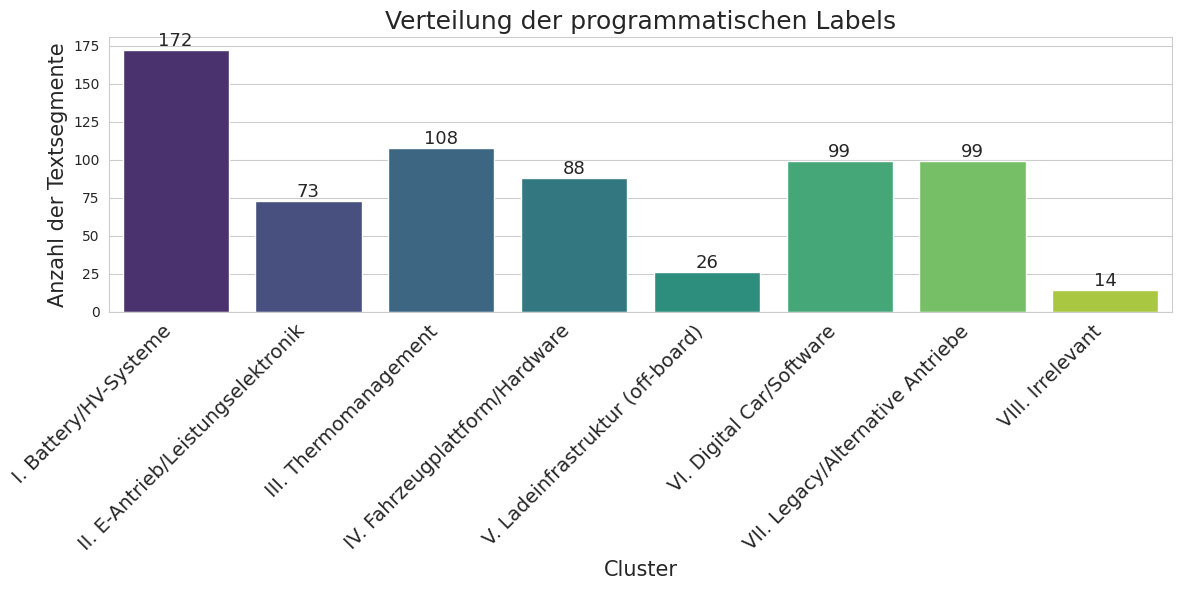

In [5]:


# Mapping für sprechende Namen im Plot
Kategorien = {1: "I. Battery/HV-Systeme", 2: "II. E-Antrieb/Leistungselektronik", 3:"III. Thermomanagement", 4: "IV. Fahrzeugplattform/Hardware",
                  5: "V. Ladeinfrastruktur (off-board)", 6: "VI. Digital Car/Software", 7: "VII. Legacy/Alternative Antriebe", 8: "VIII. Irrelevant"}

# Vorbereitung: Split & Explode, damit Texte mit mehreren Labels (z.B. "1,6")
# in der Statistik für beide Kategorien gezählt werden.
plot_daten = datensatz['vorhergesagte_labels'].str.split(',').explode().value_counts().sort_index()

# IDs im Index durch echte Namen ersetzen
plot_daten.index = plot_daten.index.astype(int).map(Kategorien)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# hue=index ist technisch nötig, damit die 'palette' ohne Warnung übernommen wird
ax = sns.barplot(x=plot_daten.index, y=plot_daten.values, hue=plot_daten.index, palette="viridis", legend=False)

# Zahlen auf die Balken schreiben
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=13)

plt.title("Verteilung der programmatischen Labels", fontsize=18)
plt.xlabel("Cluster", fontsize=15)
plt.ylabel("Anzahl der Textsegmente", fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=14)


plt.tight_layout()
plt.show()

In [6]:
# Initialisierung der ML-Pipeline
# Shuffle: Daten einmal durchmischen, damit Training/Test-Split fair ist
daten_ml = datensatz.sample(frac=1, random_state=42).reset_index(drop=True)

# Parsing: Die Strings "1,3" in echte Listen [1, 3] umwandeln
# (Da wir vorher sichergestellt haben, dass keine leeren Felder existieren, reicht ein einfacher Split)
daten_ml['label_liste'] = daten_ml['vorhergesagte_labels'].apply(lambda x: [int(i) for i in str(x).split(',')])

# One-Hot Encoding:
# Beispiel: [1, 3] wird in [1, 0, 1, 0, ...] umgewandelt
ml_binarizer = MultiLabelBinarizer(classes=list(range(1, 9)))
daten_ml['label_onehot'] = list(ml_binarizer.fit_transform(daten_ml['label_liste']))


In [7]:
# Modelltraining und Validierung (Cross-Validation)
# Wir nutzen GroupKFold, damit alle Texte einer Firma immer zusammenbleiben
# (entweder alle im Training oder alle im Test). Das verhindert Data Leakage.
gruppen_k_fold = GroupKFold(n_splits=3)
metriken = {'macro':[],'micro':[],'weighted':[]}

# Initialisierung eines Null-Arrays zur Speicherung der aggregierten Test-Vorhersagen
oof_vorhersagen = np.zeros((len(daten_ml), 8), dtype=int)

for runde, (train_idx, test_idx) in enumerate(gruppen_k_fold.split(daten_ml, groups=daten_ml['firma'])):
    # Split erstellen
    train_daten = daten_ml.iloc[train_idx]
    test_daten  = daten_ml.iloc[test_idx]

    # Konvertierung der Pandas-DataFrames in das
    # von der Hugging Face Bibliothek benötigte 'Dataset'-Format.
    ds_train = Dataset.from_pandas(train_daten[['text_segment', 'label_onehot']].rename(columns={'text_segment':'text', 'label_onehot':'label'}))
    ds_test  = Dataset.from_pandas(test_daten[['text_segment', 'label_onehot']].rename(columns={'text_segment':'text', 'label_onehot':'label'}))

    # Modell-Initialisierung:
    modell = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2", multi_target_strategy="one-vs-rest")

    # Konfiguration des Trainers
    trainer = Trainer(model=modell, args=TrainingArguments(num_epochs=3, batch_size=16, num_iterations=20, seed=42, report_to="none"),
        train_dataset=ds_train)
    trainer.train()

    # Vorhersage auf dem Test-Set
    preds = modell.predict(ds_test['text'])

    # Speichern der Vorhersagen im globalen OOF-Array
    oof_vorhersagen[test_idx] = preds

    # Evaluation der aktuellen Fold-Performance
    y_true = np.array(ds_test['label'])
    f1_macro = f1_score(y_true, preds, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, preds, average='micro', zero_division=0)
    f1_weighted = f1_score(y_true, preds, average='weighted', zero_division=0)

    metriken['macro'].append(f1_macro)
    metriken['micro'].append(f1_micro)
    metriken['weighted'].append(f1_weighted)

    print(f"Fold {runde+1} | Macro: {f1_macro:.1%} | Micro: {f1_micro:.1%} | Weighted: {f1_weighted:.1%}")

    # Explizite Freigabe des belegten VRAMs (GPU-Speicher) und RAMs nach jedem Fold,
    # um Speicherüberläufe (Out-of-Memory Errors) während der Cross-Validation zu verhindern.
    del modell, trainer
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/190 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7600
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.421300
50,0.263300
100,0.192100
150,0.173500
200,0.150600
250,0.132200
300,0.123500
350,0.120900
400,0.108900
450,0.102400


Fold 1 | Macro: 48.2% | Micro: 67.3% | Weighted: 64.4%


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/191 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7640
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.459600
50,0.275300
100,0.209500
150,0.175800
200,0.170000
250,0.153700
300,0.146500
350,0.136900
400,0.127100
450,0.127800


Fold 2 | Macro: 45.7% | Micro: 65.4% | Weighted: 62.1%


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/189 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7560
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.303600
50,0.267900
100,0.205100
150,0.176300
200,0.164900
250,0.144400
300,0.140700
350,0.136000
400,0.119700
450,0.122100


Fold 3 | Macro: 43.4% | Micro: 64.0% | Weighted: 57.1%


In [8]:
# Evaluierung

print(f"Durchschnitt über alle Folds:")
print(f"Macro-F1: {np.mean(metriken['macro']):.1%} ± {np.std(metriken['macro']):.1%}")
print(f"Weighted-F1: {np.mean(metriken['weighted']):.1%} ± {np.std(metriken['weighted']):.1%}")
print(f"Micro-F1: {np.mean(metriken['micro']):.1%} ± {np.std(metriken['micro']):.1%}")

# Rückumwandlung: One-Hot -> Label-Liste
# Fallback: Wenn das Modell gar nichts vorhersagt (leere Liste), setzen wir '8' (Irrelevant).
daten_ml['ml_vorhersagen'] = [list(x) if len(x) > 0 else [8] for x in ml_binarizer.inverse_transform(oof_vorhersagen)]

Durchschnitt über alle Folds:
Macro-F1: 45.7% ± 2.0%
Weighted-F1: 61.2% ± 3.0%
Micro-F1: 65.6% ± 1.4%


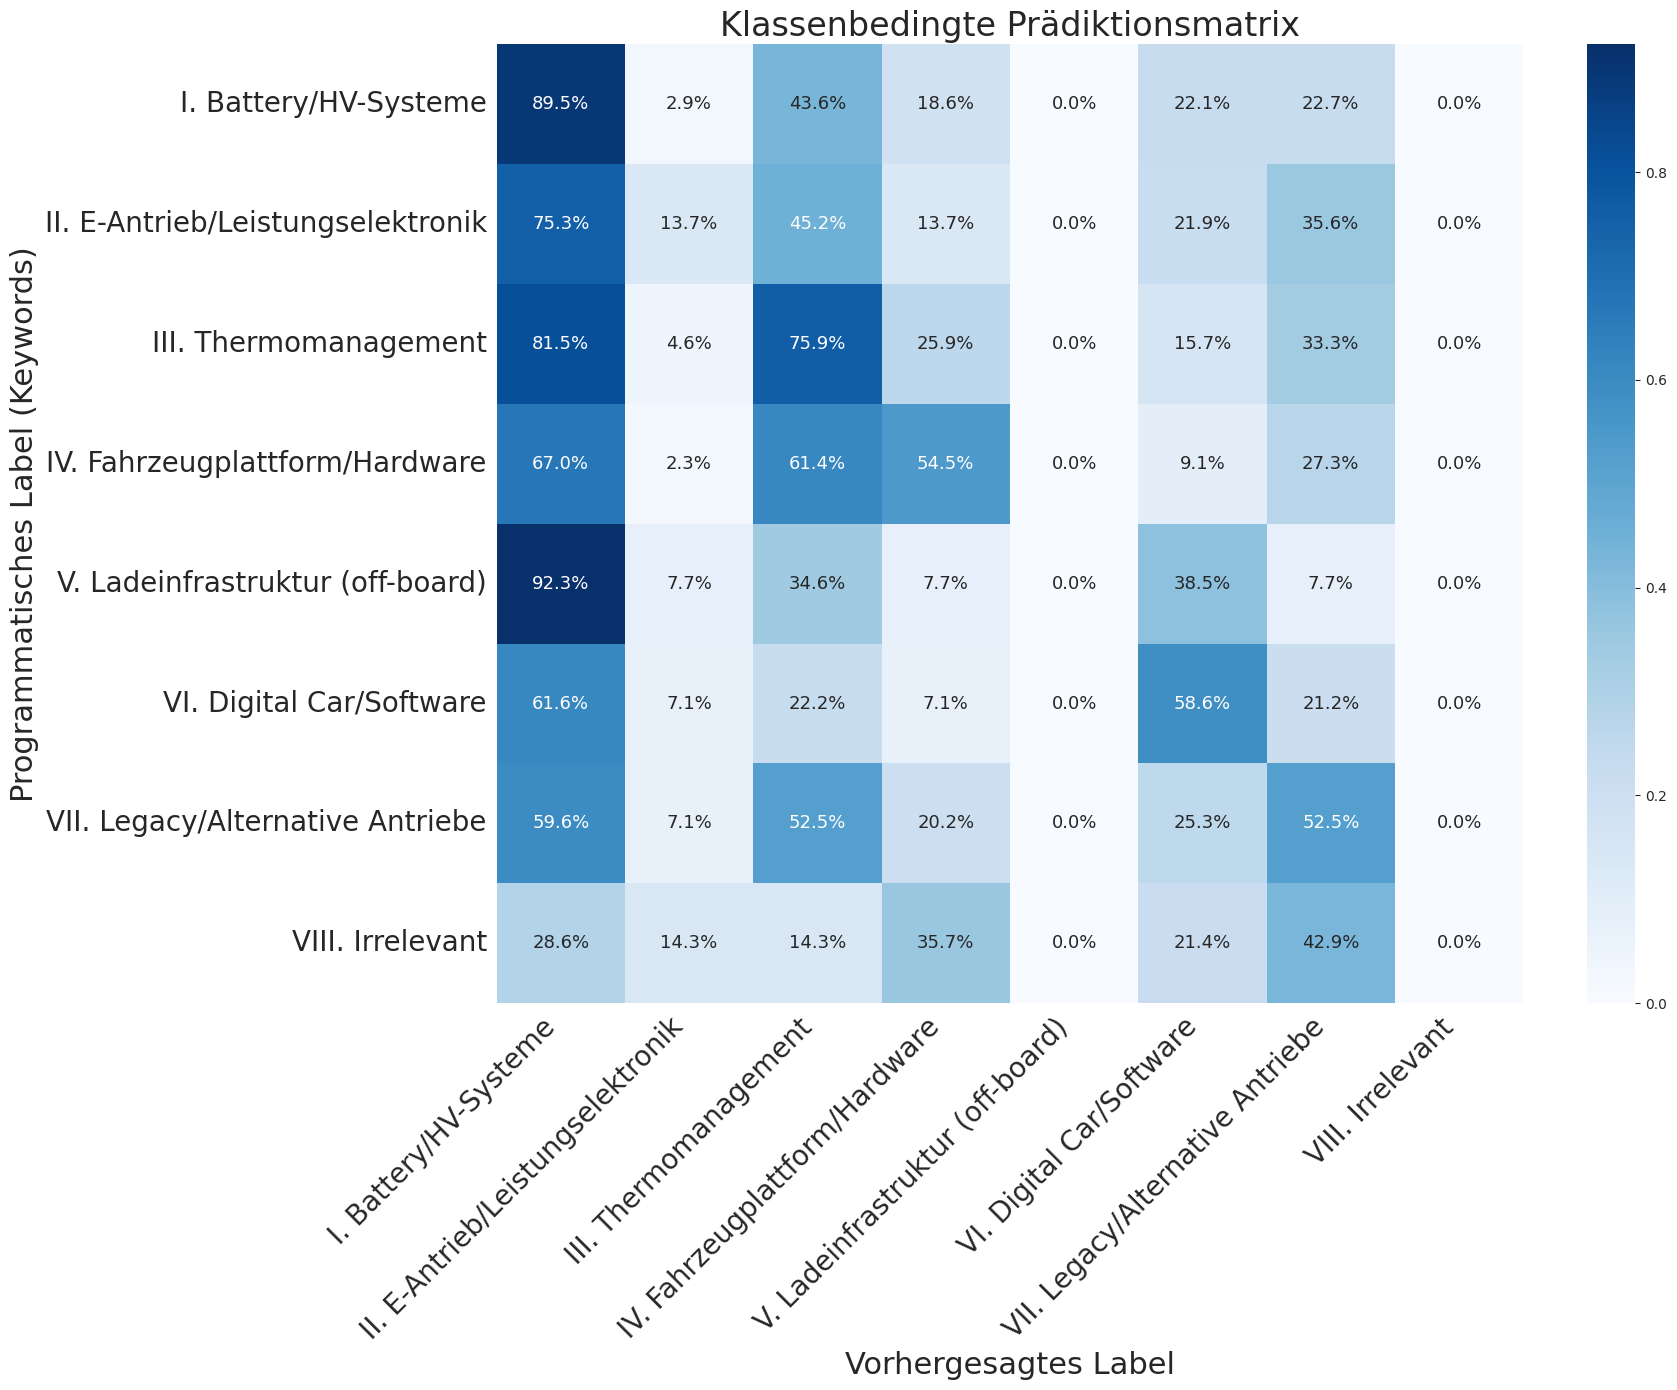

In [9]:
# Klassenbedingte Prädiktionsmatrix: Für jede Klasse c wird der Anteil
# der Segmente berechnet, für die das Modell Klasse p vorhersagt.
# Diagonale = Recall, Off-Diagonale = Ko-Prädiktionsraten.

y_true_matrix = np.array(list(daten_ml['label_onehot']))
y_pred_matrix = oof_vorhersagen

label_ids = list(range(1, 9))
cm = np.zeros((8, 8))

for c in range(8):
    # Alle Segmente, bei denen Cluster c tatsächlich vorliegt
    maske = y_true_matrix[:, c] == 1
    n_true = maske.sum()
    if n_true > 0:
        for p in range(8):
            # Anteil dieser Segmente, für die das Modell Cluster p vorhersagt
            cm[c, p] = y_pred_matrix[maske, p].sum() / n_true

plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues', annot_kws={'size': 13}, xticklabels=[Kategorien[i] for i in label_ids], yticklabels=[Kategorien[i] for i in label_ids])

plt.title('Klassenbedingte Prädiktionsmatrix', fontsize=24)
plt.xlabel('Vorhergesagtes Label', fontsize=22)
plt.ylabel('Programmatisches Label (Keywords)', fontsize=22)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(rotation=0, fontsize=20)
plt.tight_layout()
plt.show()

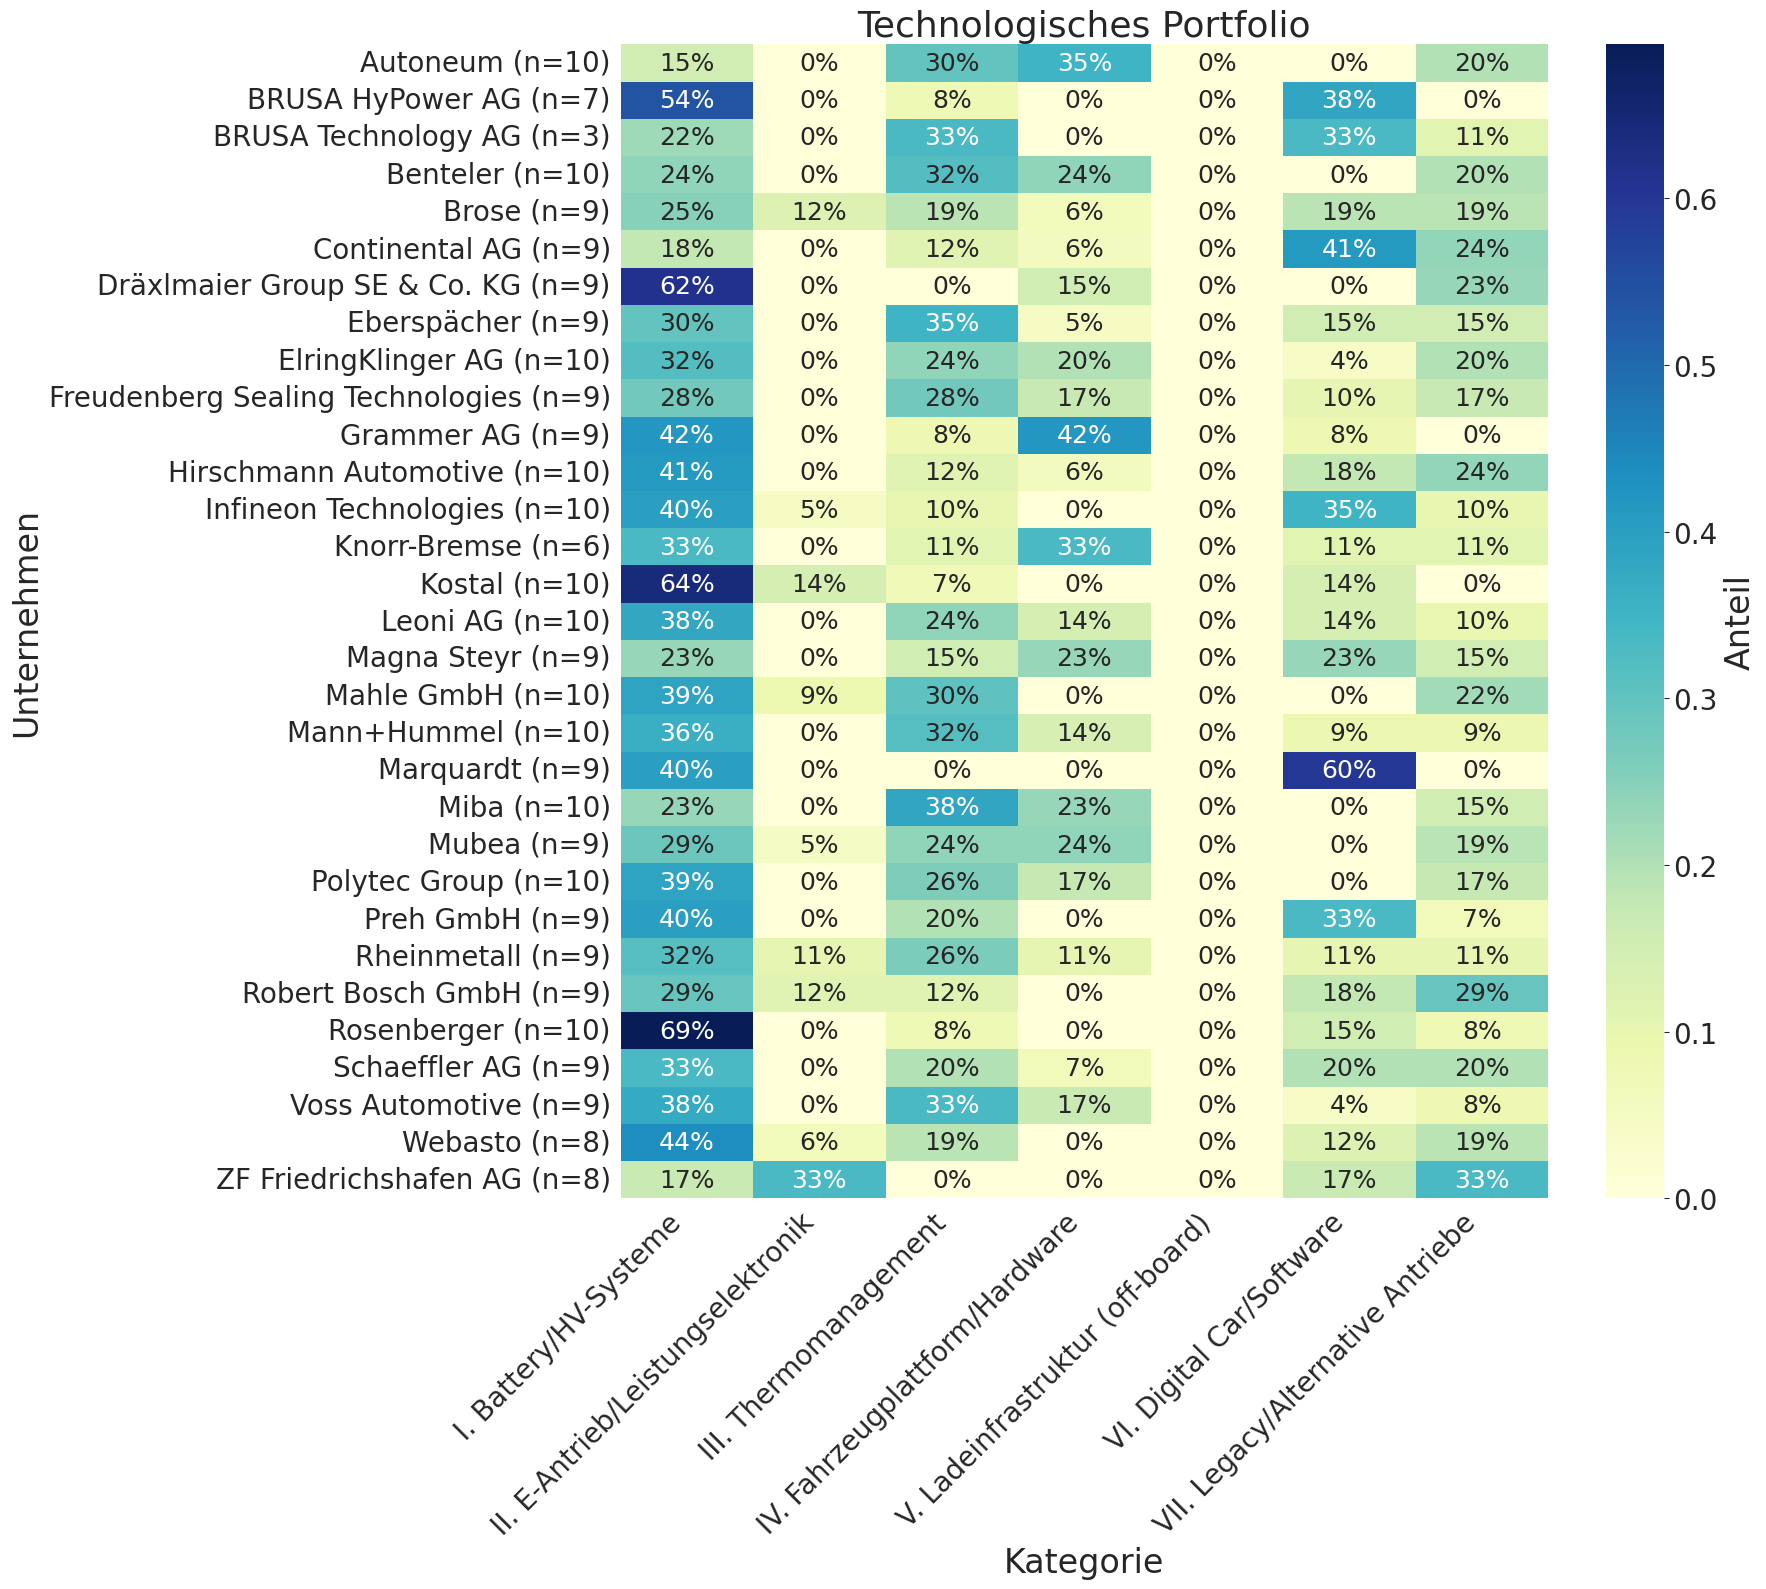

In [10]:
# Technologie-Profile der Unternehmen als Heatmap.

# Label 8 (Irrelevant) wird aus den Vorhersagen entfernt, nicht das ganze Segment.
# So geht z.B. bei einer Vorhersage [4, 8] die Cluster-4-Info nicht verloren.
df_heat = daten_ml.copy()
df_heat['ml_vorhersagen_clean'] = df_heat['ml_vorhersagen'].apply(
    lambda x: [l for l in x if l != 8]
)
# Nur Segmente entfernen, die ausschließlich 8 enthielten (leere Liste nach Filter)
df_heat = df_heat[df_heat['ml_vorhersagen_clean'].apply(len) > 0]

# Listen "explodieren" und IDs zu Namen mappen
df_expl = df_heat.explode('ml_vorhersagen_clean')
df_expl['Kategorie'] = df_expl['ml_vorhersagen_clean'].map(Kategorien)

# Kreuztabelle erstellen (Anteile pro Firma in %)
matrix = pd.crosstab(df_expl['firma'], df_expl['Kategorie'], normalize='index')

# Sicherstellen, dass alle Kategorien 1-7 als Spalten existieren
soll_spalten = [Kategorien[i] for i in range(1, 8)]
matrix = matrix.reindex(columns=soll_spalten, fill_value=0.0)

# Segmentzahl pro Firma anzeigen, damit man sieht wie belastbar die Profile sind
anzahl_segmente = df_heat.groupby('firma').size()
matrix.index = [f"{firma} (n={anzahl_segmente.get(firma, 0)})" for firma in matrix.index]

plt.figure(figsize=(18, 16))
ax = sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt=".0%", cbar_kws={'label': 'Anteil'}, annot_kws={'size': 18})

cbar = ax.collections[0].colorbar
cbar.set_label('Anteil', fontsize=24)
cbar.ax.tick_params(labelsize=20)

plt.title('Technologisches Portfolio', fontsize=26)
plt.ylabel('Unternehmen', fontsize=24)
plt.xlabel('Kategorie', fontsize=24)
plt.xticks(rotation=45, ha="right", fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
